In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

from sklearn.preprocessing import MinMaxScaler,MaxAbsScaler,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import joblib

import tensorflow as tf 
from tensorflow import keras
from keras_tuner import RandomSearch

## Data Preparation 

In [2]:
data10 = pd.read_pickle('d_data_10.pkl')
thck10 = pd.read_pickle('d_thck_10.pkl')

In [3]:
i_put = []
o_put = []
for key in data10.keys():
    i_img = data10[key]['imgs']
    o_put.append(thck10[key])
    i_put.append(np.array([i_img[k] for k in range(len(i_img))]))
o_put = np.concatenate(o_put) 
i_put = np.concatenate(i_put) 

In [4]:
target10 = o_put.copy()
images10 = i_put.copy()

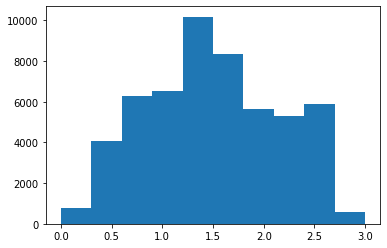

In [5]:
#sns.histplot(o_put)
plt.hist(o_put)
plt.show()

In [5]:
print(len(o_put))
len(i_put)

53576


53576

In [ ]:
#minmaxscaler 

In [6]:
scaler_transform_10 = MinMaxScaler()
target10_scaled = scaler_transform_10.fit_transform(target10.reshape(-1,1))
target10_scaled = target10_scaled.ravel()

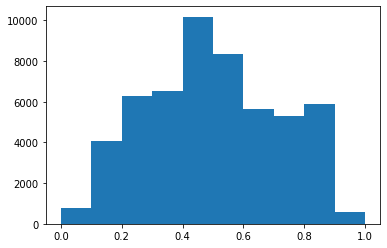

In [7]:
plt.hist(target10_scaled)
plt.show()

In [8]:
# saving transformer 
#joblib.dump(scaler_transform_10,'scaler_transform_10')

['scaler_transform_10']

In [8]:
print(np.array(np.where(target10_scaled<=0.30)).flatten().shape)
print(np.array(np.where((target10_scaled>0.30) & (target10_scaled<=0.50))).flatten().shape)
print(np.array(np.where((target10_scaled>0.50) & (target10_scaled<=0.70))).flatten().shape)
print(np.array(np.where(target10_scaled>0.7)).flatten().shape)

(11100,)
(16731,)
(13967,)
(11778,)


In [19]:
bins = np.array([-0.9,0.3,0.5,0.7,1])
target10_scaled = np.digitize(target10_scaled,bins,right=True)
target10_scaled

array([2, 2, 2, ..., 1, 1, 3], dtype=int64)

In [20]:
print(np.unique(target10_scaled))

pd.DataFrame(target10_scaled).value_counts()

[1 2 3 4]


2    16731
3    13967
4    11778
1    11100
dtype: int64

In [ ]:
# target10_scaled = np.where(target10_scaled>=0.70,3,target10_scaled)
# target10_scaled = np.where((target10_scaled>0.50) & (target10_scaled<=0.70),2,target10_scaled)
# target10_scaled = np.where((target10_scaled>0.30) & (target10_scaled<=0.50),1,target10_scaled)
# target10_scaled = np.where(target10_scaled<=0.30,0,target10_scaled)

In [10]:
images10 = images10.reshape(len(images10),32,32,1)
images10 = images10/255.0

In [11]:
x_train, x_test, y_train, y_test = train_test_split(images10,target10_scaled,test_size=0.2,random_state=2)

## model building 
### Model1

In [17]:
best_model1 = RandomSearch(hyper_model,objective='val_accuracy',max_trials = 10, directory = 'hyperparameter_models',project_name='3rd_model')
hyp = best_model1.get_best_hyperparameters()[0]
hyp.values

INFO:tensorflow:Reloading Oracle from existing project hyperparameter_models\3rd_model\oracle.json
INFO:tensorflow:Reloading Tuner from hyperparameter_models\3rd_model\tuner0.json


{'conv_1_filter': 32,
 'conv_1_kernel': 5,
 'conv_2_filter': 128,
 'conv_2_kernel': 5,
 'dense_1_units': 112,
 'learning_rate': 0.001}

In [36]:
model = keras.Sequential([
    keras.layers.Conv2D(filters = 32,kernel_size = (5,5), activation ='relu',input_shape=(32,32,1)),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Dropout(0.2),
    
    keras.layers.Conv2D(filters = 128, kernel_size=(5,5), activation ='relu'),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Dropout(0.2),
    
    keras.layers.Flatten(),
    
    keras.layers.Dense(112,activation='relu'),
    keras.layers.Dense(4, activation= 'softmax')])

model.compile(optimizer = keras.optimizers.Adam(learning_rate=0.001),
              loss = 'sparse_categorical_crossentropy',
             metrics = ['accuracy'])

In [37]:
model.fit(x_train,y_train,epochs=10)

Epoch 1/10
1340/1340 [==============================] - 78s 58ms/step - loss: 1.1454 - accuracy: 0.49540s - loss: 1.1454 - accuracy: 0.49
Epoch 2/10
1340/1340 [==============================] - 71s 53ms/step - loss: 0.9384 - accuracy: 0.6130
Epoch 3/10
1340/1340 [==============================] - 72s 54ms/step - loss: 0.8363 - accuracy: 0.6619
Epoch 4/10
1340/1340 [==============================] - 72s 54ms/step - loss: 0.7611 - accuracy: 0.6948
Epoch 5/10
1340/1340 [==============================] - 73s 54ms/step - loss: 0.7072 - accuracy: 0.7174
Epoch 6/10
1340/1340 [==============================] - 73s 54ms/step - loss: 0.6611 - accuracy: 0.7367
Epoch 7/10
1340/1340 [==============================] - 73s 54ms/step - loss: 0.6239 - accuracy: 0.7532
Epoch 8/10
1340/1340 [==============================] - 71s 53ms/step - loss: 0.5969 - accuracy: 0.7608
Epoch 9/10
1340/1340 [==============================] - 73s 54ms/step - loss: 0.5690 - accuracy: 0.7746
Epoch 10/10
1340/1340 [=======

In [39]:
model.evaluate(x_test,y_test)

335/335 [==============================] - 5s 13ms/step - loss: 0.6294 - accuracy: 0.7615


[0.6293536424636841, 0.7614781856536865]

## hyperparameter tunning 
### Model2 

In [15]:
def hyper_model(hp):
    model = keras.Sequential([
    keras.layers.Conv2D( filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
        activation='relu',
        input_shape=(32,32,1)),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Dropout(0.2),
        
    keras.layers.Conv2D( filters=hp.Int('conv_2_filter', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
        activation='relu'),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Dropout(0.2),
              
    keras.layers.Flatten(),
      
    keras.layers.Dense(units=hp.Int('dense_1_units', min_value=32, max_value=128, step=16),activation='relu'),

    keras.layers.Dense(4, activation='softmax')])
    
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    return model

In [40]:
best_model2 = RandomSearch(hyper_model,objective='val_accuracy',max_trials = 10, directory = 'hyperparameter_models',project_name='4th_model')

In [41]:
best_model2.search(x_train,y_train,epochs=5,validation_data=(x_test,y_test))

Trial 10 Complete [00h 11m 04s]
val_accuracy: 0.7058603763580322

Best val_accuracy So Far: 0.7058603763580322
Total elapsed time: 01h 26m 12s
INFO:tensorflow:Oracle triggered exit


In [43]:
model2 = best_model2.get_best_models()[0]
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 96)        960       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 96)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 15, 15, 96)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 96)        83040     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 96)         0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 6, 6, 96)          0

In [44]:
model2.evaluate(x_test,y_test)

335/335 [==============================] - 8s 24ms/step - loss: 0.7498 - accuracy: 0.7059


[0.749832034111023, 0.7058603763580322]

In [45]:
model2.fit(x_train,y_train,initial_epoch=5,epochs=10)

Epoch 6/10
1340/1340 [==============================] - 120s 89ms/step - loss: 0.6841 - accuracy: 0.7297
Epoch 7/10
1340/1340 [==============================] - 107s 80ms/step - loss: 0.6442 - accuracy: 0.7439
Epoch 8/10
1340/1340 [==============================] - 111s 83ms/step - loss: 0.6090 - accuracy: 0.7586
Epoch 9/10
1340/1340 [==============================] - 107s 80ms/step - loss: 0.5833 - accuracy: 0.7702
Epoch 10/10
1340/1340 [==============================] - 107s 80ms/step - loss: 0.5595 - accuracy: 0.7811


In [46]:
model2.evaluate(x_test,y_test)

335/335 [==============================] - 6s 18ms/step - loss: 0.6814 - accuracy: 0.7422


[0.6813571453094482, 0.7421612739562988]

## Tessting models with Data_8 and Data_5

In [ ]:
# testing Data 05 

In [48]:
data05 = pd.read_pickle('d_data_05.pkl')
thck05 = pd.read_pickle('d_thck_05.pkl')

i_put_05 = []
o_put_05 = []
for key in data05.keys():
    i_img_05 = data05[key]['imgs']
    o_put_05.append(thck05[key])
    i_put_05.append(np.array([i_img_05[k] for k in range(len(i_img_05))]))
    
i_put_05 = np.concatenate(i_put_05) 
o_put_05 = np.concatenate(o_put_05) 

o_put_05 = scaler_transform_10.transform(o_put_05.reshape(-1,1))
o_put_05 = o_put_05.ravel()
o_put_05

o_put_05 = np.digitize(o_put_05,bins,right=True)

images_TestData_5 = i_put_05.reshape(len(i_put_05),32,32,1)
images_TestData_5 = images_TestData_5/255.0

print(model.evaluate(images_TestData_5,o_put_05))
print(model2.evaluate(images_TestData_5,o_put_05))

1675/1675 [==============================] - 17s 10ms/step - loss: 1.3879 - accuracy: 0.5117
[1.3879057168960571, 0.5116656422615051]
1675/1675 [==============================] - 32s 19ms/step - loss: 1.4555 - accuracy: 0.5029
[1.455491065979004, 0.5029117465019226]


In [ ]:
# testing Data 08

In [55]:
data08 = pd.read_pickle('d_data_08.pkl')
thck08 = pd.read_pickle('d_thck_08.pkl')

i_put_08 = []
o_put_08 = []
for key in data08.keys():
    i_img_08 = data08[key]['imgs']
    o_put_08.append(thck08[key])
    i_put_08.append(np.array([i_img_08[k] for k in range(len(i_img_08))]))
    
i_put_08 = np.concatenate(i_put_08) 
o_put_08 = np.concatenate(o_put_08) 

o_put_08 = scaler_transform_10.transform(o_put_08.reshape(-1,1))
o_put_08 = o_put_08.ravel()

o_put_08 = np.digitize(o_put_08,bins,right=True)

images_TestData_8 = i_put_08.reshape(len(i_put_08),32,32,1)
images_TestData_8 = images_TestData_8/255.0

print('Model1 -',model.evaluate(images_TestData_8,o_put_08))
print('\n')
print('Model2 -',model2.evaluate(images_TestData_8,o_put_08))

1675/1675 [==============================] - 17s 10ms/step - loss: 0.7661 - accuracy: 0.7016
Model1 - [0.7660661935806274, 0.7015827894210815]


1675/1675 [==============================] - 31s 19ms/step - loss: 0.8281 - accuracy: 0.6796
Model2 - [0.8281142115592957, 0.6795580387115479]


In [56]:
#saving models
# model.save('Model_Data10_1st')
# model2.save('Model_Data10_2nd')

INFO:tensorflow:Assets written to: Model_Data10_1st\assets
INFO:tensorflow:Assets written to: Model_Data10_2nd\assets


In [ ]:
#### Model 3 made using Data_10

# model1 with 10 epochs - 78% accuracy on training data and 76% on testing data 

# model2 with 5 epochs - 70% on testing data 
# model2 with 10 epochs - 78% accuracy on training data and 74% on testing data 

### Data_05
# Model1 - accuracy of 51% 
# model2 - accuracy of 50% 

### Data_08
# Model1 - accuracy of 70% 
# model2 - accuracy of 67% 